In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")

In [2]:
baseline_harmonized = pyreadr.read_r(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/merged/baseline_harmonized_07272023.rds"
)[None].set_index("who")

relapse_harmonized_wide = pyreadr.read_r(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/merged/relapse_harmonized_wide_09062023.rds"
)[None].set_index("who")

In [13]:
baseline_harmonized.groupby(by="project").mean()

,age,hasBrainDamage,hasEpilepsy,hasSchiz,hasBipolar,hasAnxPan,hasMajorDep,bamphetamine30_base,bcannabis30_base,bbenzo30_base,ivdrug
project,,,,,,,,,,,
27,36.873479,0.088618,0.030819,0.024351,0.116883,0.301948,0.277372,0.125914,0.289196,0.164907,0.700487
30,32.058333,0.175000,0.025000,0.002793,0.058496,0.341667,0.361111,0.072222,0.394444,0.333333,0.022222
51,33.662447,0.139241,0.090717,0.012658,0.147679,0.464135,0.322785,0.202532,0.455696,0.270042,0.725000
55,45.875000,1.000000,0.000000,NaN,0.888889,1.000000,0.750000,0.916667,4.666667,0.083333,0.208333
67,47.359649,0.500000,0.666667,0.882353,0.857143,0.860000,0.811321,0.318584,4.368421,1.008772,0.394737


In [16]:
ct94 = baseline_harmonized.loc[
    (baseline_harmonized["project"] == "27")
    + (baseline_harmonized["project"] == "30")
    + (baseline_harmonized["project"] == "51")
]

Text(0, 0.5, 'relapse')

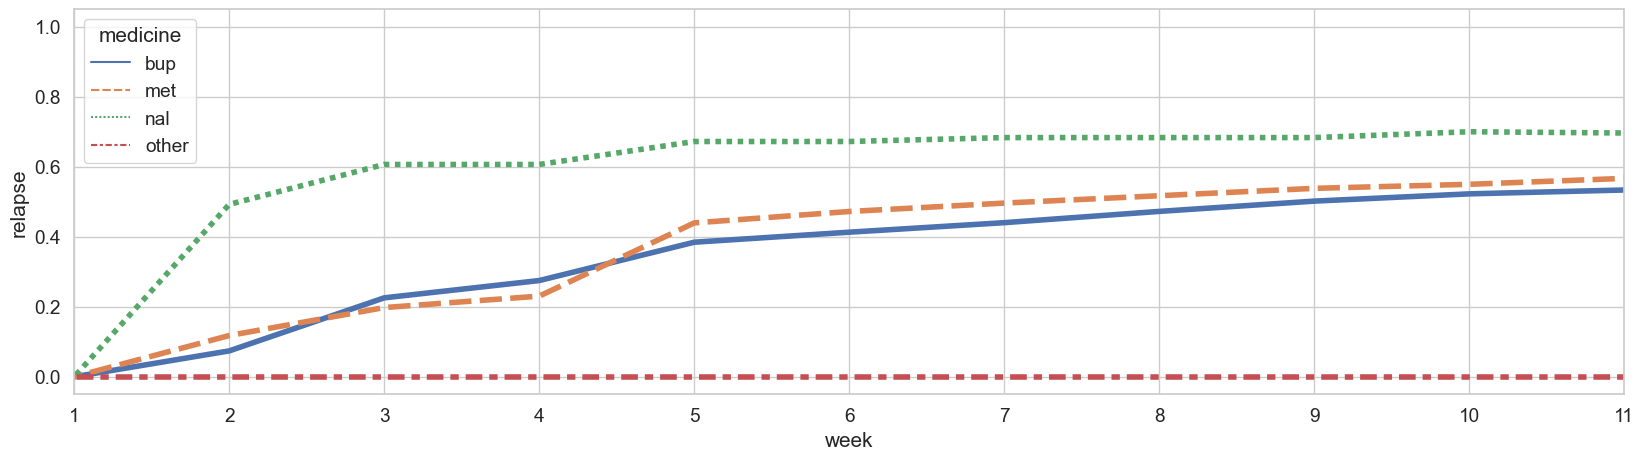

In [3]:
fig, ax = plt.subplots(figsize=(20, 5))
g = sns.lineplot(
    relapse_harmonized_wide.groupby(by=["medicine"])
    .mean()[[col for col in relapse_harmonized_wide.columns if "relapse" in col]]
    .T,
    ci="sd",
    ax=ax,
    lw=4,
)
g = plt.xticks(
    np.arange(1, 12),
    np.arange(1, 12),
)
plt.xlim(1, 11)
plt.xlabel("week")
plt.ylabel("relapse")

In [27]:
# cols_to_use = relapse_harmonized_wide.columns.difference(baseline_harmonized.columns)
cols_to_use = ["switched_meds", "wk10.relapse_this_week"]
data = baseline_harmonized.join(relapse_harmonized_wide[cols_to_use])
data_no_switch = data.loc[data["switched_meds"] != True]
# data_no_switch = data_no_switch
data_no_switch = data_no_switch.dropna().drop(
    columns=["switched_meds", "rand_dt", "end_of_detox", "site", "hwithdraw", "trt"]
)

data_no_switch = pd.get_dummies(
    data_no_switch, columns=["sex", "medicine", "project"]
).astype(int)

data_no_switch = data_no_switch.drop(
    columns=[
        "project_30",
        "project_51",
        "project_55",
        "project_67",
        "medicine_nal",
        "medicine_other",
        "medicine_met",
        "sex_female",
    ]
)

In [33]:
np.random.seed(0)
ATE_exp = (
    data_no_switch.loc[
        (data_no_switch["medicine_bup"] == 1) * (data_no_switch["project_27"] == 1),
        "wk10.relapse_this_week",
    ].mean()
    - data_no_switch.loc[
        (data_no_switch["medicine_bup"] == 0) * (data_no_switch["project_27"] == 1),
        "wk10.relapse_this_week",
    ].mean()
)
print("E[ Y(bup) - Y(met) | S=27 ]: " + str(ATE_exp))
print(
    "E[Y(bup) | S=27]: "
    + str(
        data_no_switch.loc[
            (data_no_switch["medicine_bup"] == 1) * (data_no_switch["project_27"] == 1),
            "wk10.relapse_this_week",
        ].mean()
    )
)
print(
    "E[Y(met) | S=27]: "
    + str(
        data_no_switch.loc[
            (data_no_switch["medicine_bup"] == 0) * (data_no_switch["project_27"] == 1),
            "wk10.relapse_this_week",
        ].mean()
    )
)
print(
    "E[ Y | T=bup, S=0]: "
    + str(
        data_no_switch.loc[
            (data_no_switch["medicine_bup"] == 1) * (data_no_switch["project_27"] == 0),
            "wk10.relapse_this_week",
        ].mean()
    )
)

E[ Y(bup) - Y(met) | S=27 ]: 0.08654204736155136
E[Y(bup) | S=27]: 0.6228323699421965
E[Y(met) | S=27]: 0.5362903225806451
E[ Y | T=bup, S=0]: 0.3270868824531516


leaf                   0.500000
age                    0.001912
xrace                  0.004204
alcdisorder            0.000418
cocdisorder            0.036192
hasBrainDamage         0.029356
hasEpilepsy            0.221142
hasSchiz               0.008026
hasBipolar             0.003404
hasAnxPan              0.017587
hasMajorDep            0.002522
bamphetamine30_base    0.037067
bcannabis30_base       0.050565
bbenzo30_base          0.015760
ivdrug                 0.068844
sex_male               0.003001
dtype: float64
Baseline Objective:0.0397
Optimized Objective (Forest):0.0181


[Text(0.4, 0.875, 'ivdrug <= 0.5\ngini = 0.5\nsamples = 888\nvalue = [436, 452]'),
 Text(0.2, 0.625, 'gini = 0.0\nsamples = 400\nvalue = [400, 0]'),
 Text(0.6, 0.625, 'hasEpilepsy <= 0.5\ngini = 0.137\nsamples = 488\nvalue = [36, 452]'),
 Text(0.4, 0.375, 'bamphetamine30_base <= 0.5\ngini = 0.042\nsamples = 462\nvalue = [10, 452]'),
 Text(0.2, 0.125, 'gini = 0.0\nsamples = 383\nvalue = [0, 383]'),
 Text(0.6, 0.125, 'gini = 0.221\nsamples = 79\nvalue = [10, 69]'),
 Text(0.8, 0.375, 'gini = 0.0\nsamples = 26\nvalue = [26, 0]')]

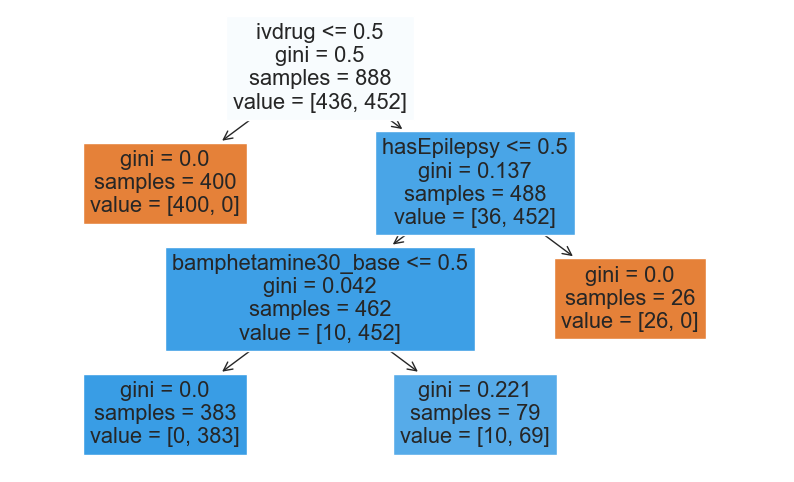

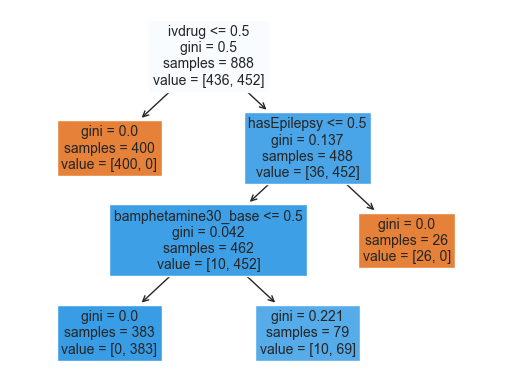

In [158]:
importlib.reload(learn)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_no_switch,
    outcome="wk10.relapse_this_week",
    treatment="medicine_bup",
    sample="project_27",
    leaf_proba=1,
    num_trees=5000,
    vote_threshold=1 / 2,
    top_k_trees=True,
    k=100,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
optimized_loss_forest = np.sqrt(
    np.sum(D_rash["vsq"] * D_rash["w_opt"]) / ((np.sum(D_rash["w_opt"])) ** 2)
)
print("Baseline Objective:%.4f" % (baseline_loss))
print("Optimized Objective (Forest):%.4f" % (optimized_loss_forest))

sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=data_no_switch.drop(
        columns=["wk10.relapse_this_week", "medicine_bup", "project_27"]
    ).columns,
    filled=True,
)


# fig, ax = plt.subplots(nrows=1, figsize=(7, 4))
# sns.histplot(
#     [
#         w_forest[i]["local objective"]
#         for i in range(len(w_forest))
#         if w_forest[i]["local objective"] < baseline_loss
#     ],
#     ax=ax,
#     fill=True,
# )
# ax.set_xlabel("objective value")
# ax.set_ylabel("number of trees")

In [20]:
stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )

In [22]:
df = stacked_list[0]
df_trial = df.loc[df["trialdata"] == 1]

In [31]:
ct94[
    [
        "sex",
        "age",
        "xrace",
        "bamphetamine30_base",
        "bbenzo30_base",
        "bcannabis30_base",
        "ivdrug",
    ]
].groupby(
    by=[
        "sex",
        "xrace",
        "bamphetamine30_base",
        "bbenzo30_base",
        "bcannabis30_base",
        "ivdrug",
    ]
).count()

age
sex    xrace bamphetamine30_base bbenzo30_base bcannabis30_base ivdrug     
female 1     0.0                 0.0           0.0              0.0     111
                                                                1.0     106
                                               1.0              0.0      58
                                                                1.0      39
                                 1.0           0.0              0.0      44
...                                                                     ...
male   4     1.0                 0.0           1.0              1.0       3
                                 1.0           0.0              0.0       0
                                                                1.0       1
                                               1.0              0.0       0
                                                                1.0       2

[128 rows x 1 columns]

In [25]:
df_trial

,sex,age,xrace,edu,mar,PREG,bamphetamine30_base,bbenzo30_base,bcannabis30_base,ivdrug,trialdata
1,0,9,1,2,1,0,0,0,0,1,1
2,1,8,3,1,3,0,0,0,1,1,1
3,1,10,3,1,2,0,0,0,0,1,1
4,1,10,3,3,3,0,1,1,1,1,1
5,1,10,3,2,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2195,0,10,1,2,1,0,1,0,1,0,1
2196,0,10,1,2,3,0,0,0,1,0,1
2197,1,7,1,3,1,0,0,0,0,0,1
2198,0,7,1,1,3,0,0,0,0,0,1


In [28]:
list(ct94.columns)

['sex',
 'age',
 'xrace',
 'project',
 'site',
 'trt',
 'rand_dt',
 'end_of_detox',
 'medicine',
 'hwithdraw',
 'alcdisorder',
 'cocdisorder',
 'hasBrainDamage',
 'hasEpilepsy',
 'hasSchiz',
 'hasBipolar',
 'hasAnxPan',
 'hasMajorDep',
 'bamphetamine30_base',
 'bcannabis30_base',
 'bbenzo30_base',
 'ivdrug']